In [17]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')

from tmm.get_jacobi_n_adjoint import get_jacobi_free_form
from film import TwoMaterialFilm, FreeFormFilm, BaseFilm
from design import DesignForFilm

from optimizer.adam_n import adam_optimize

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

inc_ang = 0.
wls = np.linspace(500, 2000, 500)

#  make target film
# np.random.seed(1)
# d = np.random.random(15)
# d *= 1000. / d.sum()

d = np.array([100, 100] * 5)
target_film = TwoMaterialFilm('1', '2', 'SiO2', d)
target_film.add_spec_param(inc_ang, wls)


In [ ]:
# thickness gd
np.random.seed(42)
init_layers = 100
d = np.random.random(init_layers)
d = d * 1000 / d.sum() # total gd = 1000 nm
rand_2m_gd_film = TwoMaterialFilm('1', '2', 'SiO2', d)
design = DesignForFilm(target_film, rand_2m_gd_film)

design.adam_gd(4000, record=True, show=True, alpha=0.1)


In [18]:

# free form gd
np.random.seed(42)
n = np.random.random(1000) + 1. # in (1, 2)
free_film = FreeFormFilm(n, 1000., 'SiO2')

# free_film.add_spec_param(inc_ang, wls)
# plot_layer_thickness(free_film)

def gd(target_film: BaseFilm, film: FreeFormFilm):
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        1000, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, 
        batch_size_wl=100
    )
    return losses, films

losses, films = gd(target_film, free_film)

with open('./films', 'wb') as  f:
    pickle.dump(films, f)

iter 0, loss 0.3259859945300398
iter 1, loss 0.24703638102868497
iter 2, loss 0.19910961574879985
iter 3, loss 0.15864844147091764
iter 4, loss 0.08818644324005324
iter 5, loss 0.05542801007366486
iter 6, loss 0.09138988458497672
iter 7, loss 0.08378929316513248
iter 8, loss 0.05635099833142972
iter 9, loss 0.02186170976702348
iter 10, loss 0.026784715476261906
iter 11, loss 0.04327377851656992
iter 12, loss 0.046696270813435574
iter 13, loss 0.046155786152353634
iter 14, loss 0.042263107562620764
iter 15, loss 0.03205357421425325
iter 16, loss 0.0180107723344783
iter 17, loss 0.03010972351106906
iter 18, loss 0.03474923809149027
iter 19, loss 0.03068771597652751
iter 20, loss 0.024507095778331375
iter 21, loss 0.019575273303174028
iter 22, loss 0.018127894385375994
iter 23, loss 0.019530303734387813
iter 24, loss 0.02124818877714007
iter 25, loss 0.021821589979596948
iter 26, loss 0.021202201611803122
iter 27, loss 0.01839533011846332
iter 28, loss 0.01833783954876199
iter 29, loss 0.

In [19]:
from analyze_utils.structure import diff_simple_film
with open('./films', 'rb') as f:
    films = pickle.load(f)
    
similarities = []

for film in films:
    similarities.append(diff_simple_film(target_film, film))
    


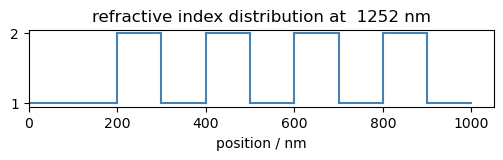

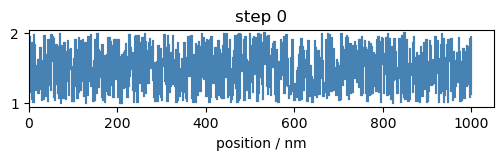

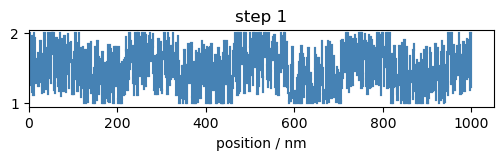

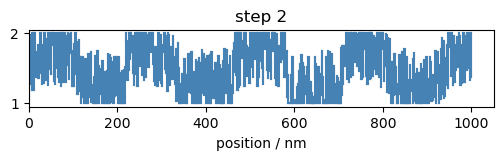

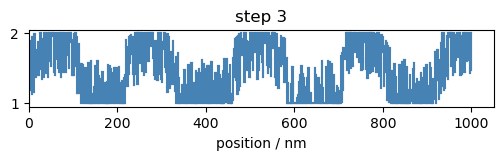

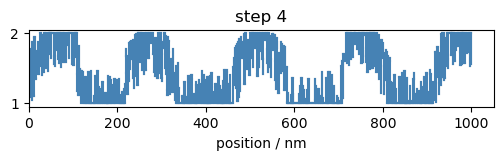

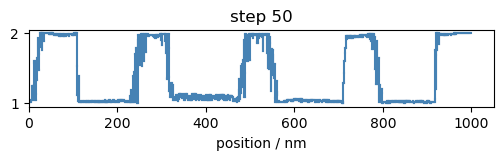

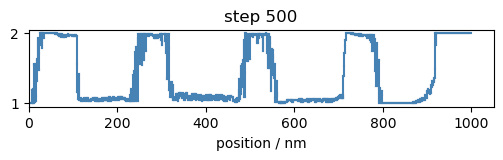

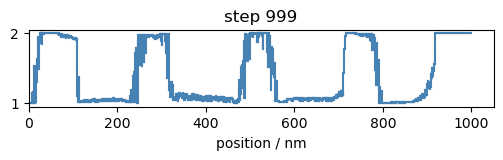

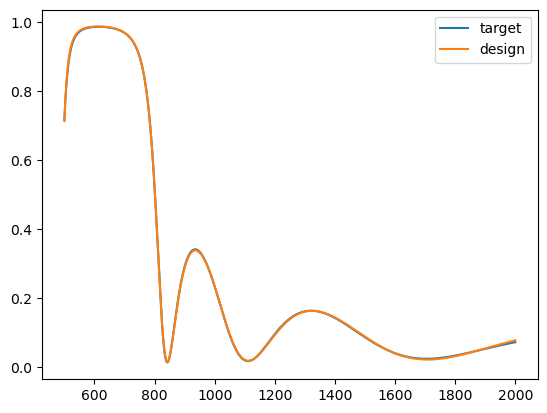

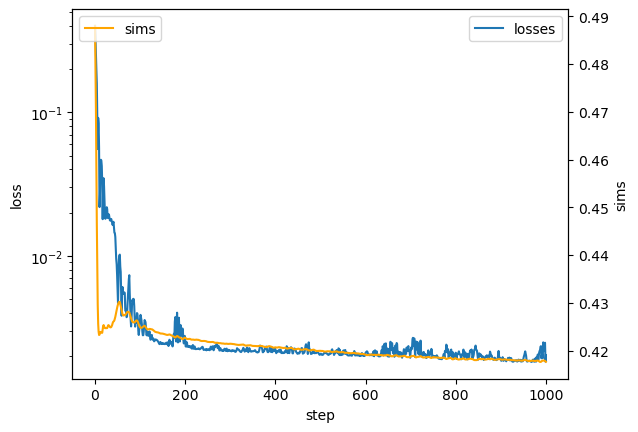

In [21]:

from analyze_utils.structure import plot_layer_thickness

plot_layer_thickness(target_film)
for i in list(range(5)) + [50, 500, 999]:
    ax, _ = plot_layer_thickness(films[i])
    ax.set_title(f'step {i}')

fig, ax = plt.subplots(1, 1)
ax.plot(wls, target_film.get_spec().get_R(), label='target')
free_film.calculate_spectrum()
ax.plot(wls, free_film.get_spec().get_R(), label='design')
ax.legend()

fig, ax = plt.subplots(1, 1)
ax.plot(losses, label='losses')
ax2 = ax.twinx()
ax2.plot(similarities, label='sims', c='orange')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax2.set_ylabel('sims')
ax.set_yscale('log')

ax.legend(loc='upper right')
ax2.legend(loc='upper left')